On importe les dépendances

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import random as rd
import math

Définition des paramètres de la simulation

In [2]:
A=0
B=500
N=101 #nombre de points de discrétisation

Delta=(B-A)/(N-1)
discretization_indexes=np.arange(N)
discretization= discretization_indexes*Delta

mu=-5
a=50
sigma2=12

observation_indexes=[0,20,40,60,80,100]
depth=np.array([0,-4,-12.8,-1,-6.5,0])

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

n=len(unknown_indexes)

In [3]:
#question 1 :
def cov(d,a,sigma2): #permet de créer la matrice de covariance à partir d'une matrice de distance
    return sigma2*np.exp(-abs(d)/a)

In [4]:
#question 2 :
D=np.array([[abs(i-j)*Delta for j in discretization_indexes] for i in discretization_indexes])

In [5]:
#question 3 : 
Z=cov(D,a,sigma2)

In [6]:
# question 4 :

# Matrice de covariance entre les observations
D_observation=np.array([[abs(i-j)*Delta for j in observation_indexes] for i in observation_indexes])
Z_observation=cov(D_observation,a,sigma2)

# Matrice de covariance entre les observations et les inconnues
D_observation_unknown=np.array([[abs(i-j)*Delta for j in unknown_indexes] for i in observation_indexes])
Z_observation_unknown=cov(D_observation_unknown,a,sigma2)

# Matrice de covariance entre les inconnues
D_unknown=np.array([[abs(i-j)*Delta for j in unknown_indexes] for i in unknown_indexes])
Z_unknown=cov(D_unknown,a,sigma2)

Question 5 :
On commence par créer un générateur de nombre suivant une loi normale centrée réduite par la méthode de Box-Muller.

In [7]:
def normale(): 
    x=rd.random()
    y=rd.random()
    return math.sqrt(-math.log(x))*math.cos(2*math.pi*y)

def vnormale(n):#renvoie un vecteur contenant n loi centrées réduites
    return np.array([normale() for i in range (n)])


On note $Y$ la variable qui représente les profondeurs inconnues et $Z$ celles des profondeurs obervées.
$Z_c$ est le vecteur des observations.

$Y_{|Z=Z_c}$ suit une loi normale d'esperance $µ+C_{Y,Z}C_Z^{-1}(Z_c - µ)$ et de matrice de covariance $CS_Y=C_Y − C_{Y,Z}C_Z^{−1}C_{Z,Y}$ où $C_Y$,$C_Z$ et $C_{Z,Y}$ sont respectivement les matrices de covariances pour les inconnues, les observations et entre observations et inconnues.

On simule $Y$ sachant $Z=Z_c$ en simulant une loi normale centrée réduite grâce à la question précédente. On la transforme alors en loi normale ayant les bons paramètres. Pour cela il faut prendre la décomposition de Cholesky de la matrice de covariance que l'on appelle $R$.

In [8]:
def var(depth,pas,observation_indexes): #retourne un vecteur qui suit la loi Y sachant Z=Zc
    R=np.linalg.cholesky(Z_unknown - np.dot(np.dot(np.transpose(Z_observation_unknown),np.linalg.inv(Z_observation)),Z_observation_unknown))
    vmu_u=np.array([mu for i in range(n)])
    vmu_o=np.array([mu for i in range(len(observation_indexes))])
    vesp=vmu_u+np.dot(np.dot(np.transpose(Z_observation_unknown),np.linalg.inv(Z_observation)),depth-vmu_o)
    return vesp + np.dot(R,vnormale(n))

On veut estimer l'espérance de profondeurs inconnues en sachant les profondeurs observées. 
L'espérance s'estime à partir de moyennes pour plusieures simulations.

In [9]:
def esperance(m=1): #renvoie une estimation de l'esperance de par la moyenne de m simulations
    S=np.zeros(n)
    for i in range(m):
        S=S+var(depth,Delta,observation_indexes)
    return S/m

On représente maintenant les résultats de la simulation.

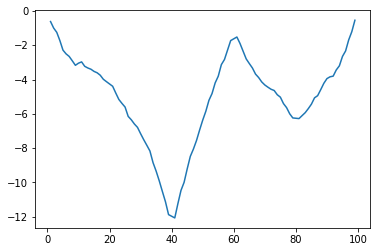

In [10]:
#affichage
def affichage(m=1):
    plt.plot(unknown_indexes,esperance(m))
    plt.show()
    
affichage(100)

Question 6 : La matrice de variance conditionnelle représente

Question 7 :
On affiche sur le même graphique la simulation et les observations.

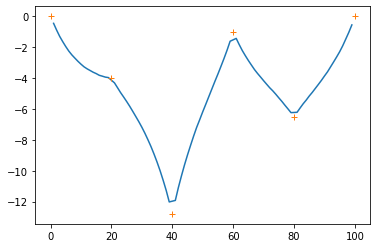

In [11]:
def affichage_mixte(m=1):
    plt.plot(unknown_indexes,esperance(m))
    plt.plot(observation_indexes,depth,'+')
    plt.show()
    
affichage_mixte(10000)

On remarque que les observations tendent à être reliées par des droites. Sur toutes les configurations possibles, en moyenne il n'y aura pas de pic intermédiaire et cela à tendance à lisser la courbe.
Par exemple en prennant peu d'étapes de simulation on peut obtenir des "pics".

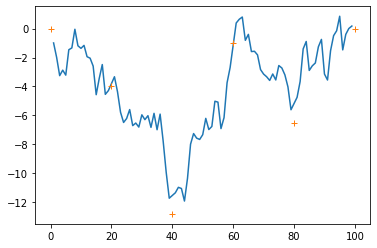

In [12]:
affichage_mixte()

Question 8 : Maintenant que l'on peut estimer la profondeur du fond marin grâce aux observations il est possible d'estimer la longueur nécessaire pour le cable. Pour chaque étape de simulation on calcule la longueur du cable puis on fait une moyenne

In [23]:
def longueur(m=1):
    S=0
    
    for k in range(m):
        #on créé une liste contenant toutes les profondeurs (observées et simulées)
        profondeur=list(var(depth, Delta, observation_indexes))
        j=0
        for i in observation_indexes:
            profondeur.insert(i,depth[j])
            j+=1
        
        s=0
        for i in range(len(profondeur)-1):
            s+=math.sqrt((profondeur[i+1]-profondeur[i])**2+Delta**2)
        
        S+=s
    
    return S/m
    
longueur(100)   

512.3787000008629

Question 9 : Si on calcule la longueur associée à l'espérance conditionnelle, on obtient :

In [14]:
def longueur_condi(m):
    profondeur=list(esperance(m))
    j=0
    for i in observation_indexes:
        profondeur.insert(i,depth[j])
        j+=1

    s=0
    for i in range(len(profondeur)-1):
        s+=math.sqrt((profondeur[i+1]-profondeur[i])**2+Delta**2)
    return s

longueur_condi(100)

501.732555913876

On remarque que la longueur est bien plus faible. Cela s'explique par le fait que comme vu précedemment, prendre l'espérance lisse le fond marin et diminue alors directement la longueur du cable nécessaire. L'estimation faisant la moyenne des longueurs générées est plus précise et réaliste et évite l'effet du au lissage

Question 10 : On calcule maintenant la suite $M_n$ qui représente l'etimation de la longueur du cable faite à partir de $n$ simulations.

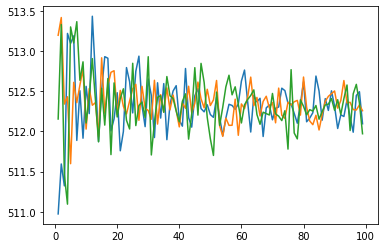

In [32]:
def Mn(m,e):
    l1=list()
    l12=list()
    l13=list()
    l2=list()
    for i in range(1,m):
        if i%e==0:
            l1.append(longueur(i))
            l12.append(longueur(i))
            l13.append(longueur(i))
            l2.append(i)
    plt.plot(l2,l1)
    plt.plot(l2,l12)
    plt.plot(l2,l13)
    plt.show()

Mn(100,1)

On remarque que d'une simulation à l'autre le début de la courbe varie légèrement mais que l'on tend toujours vers la même limite. Cela s'explique par le fait que les premiers termes de $M_n$ ne dépendent que du résultats de peu de simulations et est donc plus variable.

Question 11 : On fait un histogramme des valeurs rencontrées pour la longueur du cable.

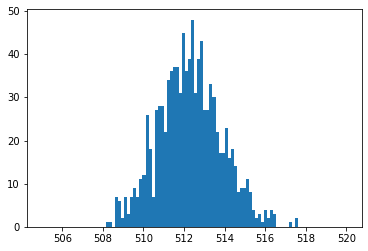

In [30]:
def histo(m):
    l=list()
    for i in range(m):
        l.append(longueur())
    plt.hist(l,range=(505,520),bins=100)
    
histo(1000)

On remarque que la figure se rapproche d'une gaussiènne avec un légère asymétrie.

Question 12 : Une première méthode consiste à approximer la distribution des longueurs en une gaussiène d'espérance $\mu$. 

On calcule l'écart-type numériquement avec la formule $\sigma=\sqrt{\frac{1}{n}\sum_{i=0}^m (l_i-\mu)^2}$ où $l_i$ est la longueur obtenue à la i-ème simulation.

In [51]:
def approximation(l):#l est la liste contenant
    sigma=0
    s=0
    for i in (l):
        s+=i
    mu=s/len(l)
    
    S=0
    for i in (l):
        S+=(i-mu)**2
    
    sigma=math.sqrt(S/len(l))
    
    return (mu,sigma)
        
print(approximation([longueur() for i in range(10000)]))

(512.3208733871592, 1.5261357448893558)


On fait maintenant les calculs avec la gaussiènne de paramètres ($\mu=512.3 , \sigma=1.5)$ (chiffres obtenus pour 10000 simulations).

On a une probabilité de 95% de trouver une longueur dans l'intervalle $[\mu-2\sigma,\mu+2\sigma]=[509.3, 
515.3]$




Question 12 : On réutilise l'approximation par une gaussiènne de la question précédente. On connait la densité de la gaussiènne qui vaut : $$f(x)=\frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu)²}{2\sigma²}}$$

On intégre alors cette densité sur l'intervalle $]-\infty,525]$.

On sait que $\int_{-\infty}^{\mu}f(x)dx=\frac{1}{2}$

On intégre alors la partie restante numériquement avec une méthode des rectangles par exemple.

In [65]:
#paramètre de la gaussiènne
mu1=512.3
sigma=1.5

In [67]:
#fonction densité
def f(x):
    return (1/(math.sqrt(2*math.pi)*sigma)) * math.exp(-(x-mu1)**2/(2*sigma**2))



In [60]:
#méthode intégration numérique
def integration(a,b,n,f):
    S=0
    delta=(b-a)/(n-1)
    for i in range(n):
        S+=delta*f(a+delta*i)
    return S

In [69]:
print(integration(mu1,525,10000,f)+0.5)

1.000168902455611


Les approximations sont trop grossières pour pour voir donner un résultat précis. Cependant on voit que cette probabilité va tendre vers 1.